## Mercedes-Benz Greener Manufacturing

> Can you cut the time a Mercedes-Benz spends on the test bench?

In [1]:
# Python and data manipulation stuff
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import TruncatedSVD

/home/hguimaraes/.virtualenvs/kaggle/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/hguimaraes/.virtualenvs/kaggle/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### EDA

The EDA analysis started based on this public kernels (Thanks a lot for this sharing):

* https://www.kaggle.com/headsortails/mercedas-2-feature-interactions
* https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-mercedes
* https://www.kaggle.com/headsortails/mercedas-update2-intrinsic-noise
        

## Helpers

In [2]:
# K-Fold helper
def kfold_validate(clf, X, y, k_folds = 5):
    acc = []
    rtimes = 5
    rstate = [420, 123, 456, 678, 666]
    for it in range(rtimes):
        count = 0
        kf = KFold(n_splits=k_folds, shuffle = True, random_state=rstate[it])
        for train_idx, test_idx in kf.split(X):
            count += 1
            # Separe training and test in the Training set for k-Fold
            fold_Xtrain, fold_Xtest = X[train_idx], X[test_idx]
            fold_ytrain, fold_ytest = y[train_idx], y[test_idx]

            # Train
            clf.fit(fold_Xtrain, fold_ytrain)
            pred = clf.predict(fold_Xtest)
            accuracy = r2_score(fold_ytest, pred)
            acc.append(accuracy)
            print("Fold: %s of % s | iter: %s => r2_score = %s" %(count, k_folds, it, accuracy))
    
    print("\nR2_score statistics:")
    print("Mean = %s%%" % '{0:.5f}'.format(np.mean(acc)))
    print("STD = %s%%" % '{0:.5f}'.format(np.std(acc)))

In [3]:
# K-Fold helper
def kfold_validate_keras(clf, X, y, k_folds = 5):
    acc = []
    rtimes = 5
    rstate = [420, 123, 456, 678, 666]
    for it in range(rtimes):
        count = 0
        kf = KFold(n_splits=k_folds, shuffle = True, random_state=rstate[it])
        for train_idx, test_idx in kf.split(X):
            count += 1
            # Separe training and test in the Training set for k-Fold
            fold_Xtrain, fold_Xtest = X[train_idx], X[test_idx]
            fold_ytrain, fold_ytest = y[train_idx], y[test_idx]

            # Train
            clf.fit(fold_Xtrain,fold_ytrain, epochs=250,
                    validation_data=(fold_Xtest, fold_ytest))
            pred = clf.predict(fold_Xtest)
            accuracy = r2_score(fold_ytest, pred)
            acc.append(accuracy)
            print("Fold: %s of % s | iter: %s => r2_score = %s" %(count, k_folds, it, accuracy))
    
    print("\nR2_score statistics:")
    print("Mean = %s%%" % '{0:.5f}'.format(np.mean(acc)))
    print("STD = %s%%" % '{0:.5f}'.format(np.std(acc)))

In [4]:
# https://www.kaggle.com/eikedehling/stack-of-svm-elasticnet-xgboost-rf-0-55
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y).ravel()
        T = np.array(T)

        folds = list(KFold(n_splits=self.n_splits, shuffle=True, random_state=1024).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        acc = []
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                    
                y_holdout = y[test_idx]

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_holdout)[:]
                accuracy = r2_score(y_holdout, y_pred)
                print ("Model %d fold %d score %f" % (i, j, accuracy))
                acc.append(accuracy)

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]
            S_test[:, i] = S_test_i.mean(axis=1)
        
        print("\nR2_score statistics for Models:")
        print("Mean = %s%%" % '{0:.5f}'.format(np.mean(acc)))
        print("STD = %s%%" % '{0:.5f}'.format(np.std(acc)))
        print("\nStarting kFold for stacked models")
        kfold_validate(self.stacker, S_train, y)
        
        # Train on all data
        self.stacker.fit(S_train, y)
        res = self.stacker.predict(S_test)[:]
        return res

In [5]:
# Test validation helper
def lb_probing(pred):
    probing = pd.read_csv('data/lb_probing.csv')
    values = []
    for idp in probing.id:
        values.append(pred.y[pred.ID == idp].values[0])
    print('lb probing score = %s' % r2_score(probing.y, np.array(values)))

## Aproach 1: Several models and stacking

### Read the data

In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [7]:
# Insert probed data
probing = pd.read_csv('data/lb_probing.csv')

for idp in probing.id:
    n_row = df_test[df_test.ID == idp]
    n_row['y'] = list(probing[probing.id == idp]['y'])
    df_train = pd.concat([df_train, n_row], axis=0)

/home/hguimaraes/.virtualenvs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Feature Engineering and Data Cleaning

In [8]:
# Get the mean for y across repeated rows
filter_col = list(df_train.columns)
filter_col.remove('ID')
filter_col.remove('y')
repeated = df_train[df_train.duplicated(subset=filter_col, keep=False)]
mean_repeated = repeated.groupby(filter_col, as_index=False).mean()

# Remove repeated rows
print(df_train.shape)
filter_col = list(df_train.columns)
filter_col.remove('ID')
filter_col.remove('y')
df_train.drop_duplicates(subset=filter_col, keep=False, inplace=True)
print(df_train.shape)

# Merge with filtered rows
df_train = pd.concat([df_train, mean_repeated], axis=0)
print(df_train.shape)

# Magic feature from Cro-Magnon
uniquex0 = list(df_train['X0'].unique())
dict_meanx0 = {}
df_train['meanx0'] = df_train.y
df_test['meanx0'] = np.repeat(np.median(df_train.y), len(df_test))

for x in uniquex0:
    meanx0 = np.median(df_train['y'][df_train['X0'] == x])
    dict_meanx0[x] = meanx0
    df_train['meanx0'][df_train['X0'] == x] = meanx0
    df_test['meanx0'][df_test['X0'] == x] = meanx0

# group train and test
num_train = len(df_train)
df_all = pd.concat([df_train, df_test], axis=0)
df_all = df_all.reset_index()

# Get the object features
obj_features = []
int_features = []
for c in df_all.columns:
    if df_all[c].dtype == 'object':
        obj_features.append(c)
    else:
        int_features.append(c)

# One-Hot Encoding
for cc in obj_features:
    dummies = pd.get_dummies(df_all[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    df_all.drop(cc, axis=1, inplace=True)
    df_all = df_all.join(dummies)

df_train = df_all[:num_train]
df_test = df_all[num_train:].drop(['y'], axis=1)

x_train = df_train.drop(['ID', 'y'], axis=1).as_matrix()
y_train = df_train.filter('y').as_matrix()
x_test = df_test.drop(['ID'], axis=1).as_matrix()
id_test = df_test['ID'].apply(int)

(4241, 378)
(3720, 378)
(3939, 378)


/home/hguimaraes/.virtualenvs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/hguimaraes/.virtualenvs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Modeling

In [9]:
# XGBoost 1
xgb_params_1 = {
    'learning_rate': 0.01,
    'n_estimators': 1024,
    'max_depth':3,
    'subsample': 1,
    'colsample_bytree':0.5,
    'reg_alpha':0.5,
    'reg_lambda':0.5
}

xgb_clf_1 = xgb.XGBRegressor(**xgb_params_1)
#if cross_validate:
#    kfold_validate(xgb_clf, x_train, y_train)
    
# Fit in all data and use on test
#xgb_clf.fit(x_train, y_train)
#xgb_pred = xgb_clf.predict(x_test)
#result = pd.DataFrame({'ID': id_test, 'y': xgb_pred})
#lb_probing(result)

In [10]:
# XGBoost 2
xgb_params_2 = {
    'learning_rate': 0.01,
    'n_estimators': 4096,
    'max_depth':5,
    'subsample': 1,
    'colsample_bytree':0.5,
    'reg_alpha':0.5,
    'reg_lambda':0.5
}

xgb_clf_2 = xgb.XGBRegressor(**xgb_params_2)

In [11]:
# LightGBM 1
gbm_params_1 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 256,
    'learning_rate': 0.01,
    'n_estimators': 500,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1,
    'num_rounds': 2000,
    'max_depth': 15,
}

gbm_clf_1 = lgb.LGBMRegressor(**gbm_params_1)

In [12]:
# LightGBM 2
gbm_params_2 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 512,
    'learning_rate': 0.01,
    'n_estimators': 2500,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1,
    'num_rounds': 5000,
    'max_depth': 15,
}

gbm_clf_2 = lgb.LGBMRegressor(**gbm_params_2)

In [13]:
# Random Forest
rf_params = {
    'n_estimators': 256,
    'n_jobs':-1
}

rf_clf = RandomForestRegressor(**rf_params)

In [14]:
# Extra Trees 1
et_params_1 = {
    'n_estimators': 64,
    'max_depth': 8,
    'n_jobs': 4
}

et_clf_1 = ExtraTreesRegressor(**et_params_1)

In [15]:
# Extra Trees 2 
et_params_2 = {
    'n_estimators': 256,
    'n_jobs': 4
}

et_clf_2 = ExtraTreesRegressor(**et_params_2)

In [16]:
# Ridge
ridge_params = {
    'alpha': 100,
    'normalize':False,
    'solver':'auto'
}

ridge_clf = Ridge(**ridge_params)

In [17]:
x_train.shape

(3939, 581)

In [18]:
# Stacked approach
stack = Ensemble(n_splits=5,
                 stacker=ElasticNet(l1_ratio=0.1, alpha=1.4),
                 base_models=(xgb_clf_1, xgb_clf_2, gbm_clf_1,
                              gbm_clf_2, rf_clf, et_clf_1))

pred_app1 = stack.fit_predict(x_train, y_train, x_test)

approach1 = pd.DataFrame({'ID': id_test, 'y': pred_app1})
approach1.to_csv('approach1.csv', index=False)
lb_probing(approach1)

Model 0 fold 0 score 0.612052
Model 0 fold 1 score 0.618006
Model 0 fold 2 score 0.609361
Model 0 fold 3 score 0.438244
Model 0 fold 4 score 0.583901
Model 1 fold 0 score 0.559892
Model 1 fold 1 score 0.586943
Model 1 fold 2 score 0.541422
Model 1 fold 3 score 0.398221
Model 1 fold 4 score 0.546522
Model 2 fold 0 score 0.589260
Model 2 fold 1 score 0.606191
Model 2 fold 2 score 0.579602
Model 2 fold 3 score 0.430109
Model 2 fold 4 score 0.567336
Model 3 fold 0 score 0.546958
Model 3 fold 1 score 0.551466
Model 3 fold 2 score 0.510604
Model 3 fold 3 score 0.397946
Model 3 fold 4 score 0.528873
Model 4 fold 0 score 0.557284
Model 4 fold 1 score 0.592531
Model 4 fold 2 score 0.586436
Model 4 fold 3 score 0.429127
Model 4 fold 4 score 0.573470
Model 5 fold 0 score 0.579873
Model 5 fold 1 score 0.572480
Model 5 fold 2 score 0.602278
Model 5 fold 3 score 0.413183
Model 5 fold 4 score 0.570520

R2_score statistics for Models:
Mean = 0.54267%
STD = 0.06723%

Starting kFold for stacked models
F

## Approach 2: Deep Learning

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras import backend as K

Using TensorFlow backend.


In [20]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [21]:
# First arch: Smaller NN
def smallNN(input_dims = 581):
    model = Sequential()

    #input layer
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # hidden layers
    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.25))

    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.25))

    model.add(Dense(input_dims//4, activation='tanh'))

    # output layer (y_pred)
    model.add(Dense(1, activation='linear'))

    # compile this model
    model.compile(loss='mean_squared_error',
        optimizer='adam',
        metrics=[r2_keras])
    return model

In [22]:
small_nn_clf = KerasRegressor(
    build_fn=smallNN, 
    nb_epoch=300, 
    batch_size=128,
    verbose=1)

# Fit in all data and use on test
small_nn_clf.fit(x_train, y_train, epochs=500, verbose=0)
small_nn_pred = small_nn_clf.predict(x_test, verbose=0)
result = pd.DataFrame({'ID': id_test, 'y': small_nn_pred})

lb_probing(result)

lb probing score = 0.572913572291


## Approach 3: Clustering

In [23]:
features = ['X118', 'X127','X47','X315','X311','X179',
            'X314','X232','X29','X263','X261']
y_clip =  np.clip(df_train['y'].values, a_min=None, a_max=130)

In [24]:
tsne = TSNE(random_state=2016,perplexity=50,verbose=2)
x = tsne.fit_transform(pd.concat([df_train.filter(features),df_test.filter(features)]))

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 8148
[t-SNE] Computed conditional probabilities for sample 2000 / 8148
[t-SNE] Computed conditional probabilities for sample 3000 / 8148
[t-SNE] Computed conditional probabilities for sample 4000 / 8148
[t-SNE] Computed conditional probabilities for sample 5000 / 8148
[t-SNE] Computed conditional probabilities for sample 6000 / 8148
[t-SNE] Computed conditional probabilities for sample 7000 / 8148
[t-SNE] Computed conditional probabilities for sample 8000 / 8148
[t-SNE] Computed conditional probabilities for sample 8148 / 8148
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 0.2608730, gradient norm = 0.0038020
[t-SNE] Iteration 50: error = 0.2565730, gradient norm = 0.0081209
[t-SNE] Iteration 75: error = 0.2289415, gradient norm = 0.0061236
[t-SNE] Iteration 100: error = 0.2205398, gradient norm = 0.0062024
[t-SNE] KL divergence aft

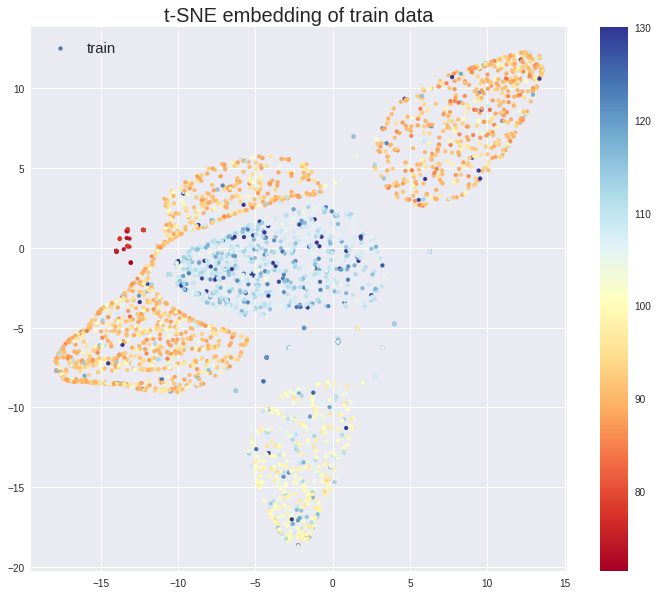

In [25]:
cm = plt.cm.get_cmap('RdYlBu')
plt.figure(figsize=(12,10))
cb = plt.scatter(x[:df_train.shape[0],0],x[:df_train.shape[0],1], c=y_clip, cmap=cm, marker='o', s=15, label='train')
plt.colorbar(cb)
plt.legend(prop={'size':15})
plt.title('t-SNE embedding of train data', fontsize=20)
plt.show()

In [26]:
from sklearn.cluster import KMeans
kmeans_params = {
    'n_clusters': 4,
    'init': 'k-means++',
    'max_iter': 300,
    'n_jobs': -1,
    'algorithm':'auto',
    'random_state': 420
}

kmeans = KMeans(**kmeans_params).fit(x[:num_train])
train_pred = kmeans.predict(x[:num_train])
test_pred = kmeans.predict(x[num_train:])

In [27]:
df_train['cluster'] = train_pred
df_test['cluster'] = test_pred

/home/hguimaraes/.virtualenvs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
# @TODO

In [29]:
# Average all models
average = pd.DataFrame({'ID': id_test, 'y': .35*small_nn_pred + .65*pred_app1})
average.to_csv('finalEnsemble.csv', index=False)
lb_probing(average)

lb probing score = 0.658862681832


## Experiments results

In this cell I will try to report all the tries that I did.

### Raw data

| Features        | Mean & STD CV 5-Fold | LB Probing |
| :-------------- |:-------------:| :-----|
| XGBoost using Label encoder | Mean = 0.56434%, STD = 0.05999% | 0.435572281085 |
| LightGBM using Label encoder | Mean = 0.55672%, STD = 0.06136% | 0.671859646279 |
| XGBoost using One Hot Encoding | Mean = 0.56819%, STD = 0.05853% | 0.463080164631 |
| LightGBM using One Hot Encoding | Mean = 0.56586%, STD = 0.06029% | 0.624736134116 |


### Removing the Y outlier

The problem with removing the outlier is that it represents a great information and is useful for some data in test set. Local CV improves but LBprobing will decrease. *"The one who can predict outliers will win this competition"*

| Features        | Mean & STD CV 5-Fold | LB Probing |
| :-------------- |:-------------:| :-----|
| XGBoost using One Hot Encoding | Mean = 0.59033%, STD = 0.02744% | 0.41257467562 |
| LightGBM using One Hot Encoding | Mean = 0.58706%, STD = 0.02747% | 0.4969397011976 |

### Removing Columns with zero variance

Trying this approach but we wont use

| Features        | Mean & STD CV 5-Fold | LB Probing |
| :-------------- |:-------------:| :-----|
| XGBoost using One Hot Encoding | Mean = 0.56744%, STD = 0.05776% | 0.456847306399 |
| LightGBM using One Hot Encoding | Mean = 0.56567%, STD = 0.06012% | 0.621702756209 |

### Removing Repeated Rows

Seems to improve LGB but not XGBoost

| Features        | Mean & STD CV 5-Fold | LB Probing |
| :-------------- |:-------------:| :-----|
| XGBoost using One Hot Encoding | Mean = 0.57143%, STD = 0.06449% | 0.461810565188 |
| LightGBM using One Hot Encoding | Mean = 0.57197%, STD = 0.06900% | 0.596767729737 |

### Using feature from Cro-Magnon

| Features        | Mean & STD CV 5-Fold | LB Probing |
| :-------------- |:-------------:| :-----|
| XGBoost using One Hot Encoding | Mean = 0.57010%, STD = 0.06372% | 0.455551275766 |
| LightGBM using One Hot Encoding | Mean = 0.57447%, STD = 0.06785% | 0.610080074095 |

### Start Stacking

Advice:
```
|-- 2 or 3 GBMs (one with low depth, one with medium and one with high)
|-- 1 or 2 Random Forests (again as diverse as possible–one low depth, one high)
|-- 1 or 2 NNs (one deeper, one smaller)
|-- 1 linear model
```